In [3]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

import pickle
import os



### Data Params  
<a id="dataparams"></a>

These parameters are pickled to file, and serve several purposes:
* The allow other programs to properly evaluate and visualize the trained (and also saved) models,
* PRovide a record of the parameters that allow reproducing results. 

In [4]:
loadmodel = False #True means load params from disk, and use last saved model running from last saved step 
restartPickledParamFilePath = 'model' + '/2018-11-22_11-41-42_modelParams.pkl'

if loadmodel == True :  # ------------   get params from file
    with open(restartPickledParamFilePath, 'rb') as input:
        params = pickle.load(input) 
    loadmodelfile=params['savemodeldir'] + '/' + params['savedModel']
    #override any of the saved params
    params['max_steps']= 2000 #in addition to whatever was already run
    
else : # ---------------------    New run, set the params
    sourcedatadir='/tmp/synth.64.76.ConstSlopeTransients_Even.1.len.6.1.0_Odd.01.len.6.2.0'
    #sourcedatadir='/tmp/nSynthTransients'
    #sourcedatadir="/home/lonce/ZCODE/PYTORCH/data/nsynth.64.76.dl"    
    #sourcedatadir="/tmp/nsynth_sm_scaled"
 

    params = dict(
        # Read/write directory of data & parameter files
        #*************************************
        sample_rate=16000,
        runTimeStamp='{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now()),
        
        datadir = sourcedatadir,
        #without a csv file, all data in datadir are used for training
        #csvfile=sourcedatadir+"/64_76.csv",
        
        paramdir = sourcedatadir + '/dataparams',


        # Save & load parameters
        #*************************************
        #--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

        savemodel = True,
        savemodel_interval = 10, #200,  #If 0 (and savemodel=True) will only save model at the end of entire training
        savemodeldir = os.getcwd() + '/model', #default saving directory for models and the parameterization
        savedModel='', #updated at savemodel_interval
        savedSteps=0,  #updated at savemodel_interval
        
        max_steps = 100, #1000,  #10000, #max number batches of steps per epoch (typically num_epochs=1)


        # Training parameters
        #*************************************
        noise=.1,
        seqLen = 256,
        stride = 1,
        batch_size = 256,
        num_epochs = 1,
        lr = 0.005,
        props=['instID','pressure1','midiPitch'],
        
        # Model parameters
        hiddenSize = 40, #100,
        nLayers = 4,
        
        lowNote=64, #52,
        hiNote=76, #86
    )



### Run Params 

In [5]:
sr = params['sample_rate']

max_steps = params['max_steps'] #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch
k_previousRunSteps=params['savedSteps']
log_interval = 50
visualize_interval = 100

#Generation parameters
#*************************************
max_length = params['seqLen']*3

# Cuda
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
params

{'sample_rate': 16000,
 'runTimeStamp': '2018-11-23_09-37-53',
 'datadir': '/tmp/synth.64.76.ConstSlopeTransients_Even.1.len.6.1.0_Odd.01.len.6.2.0',
 'paramdir': '/tmp/synth.64.76.ConstSlopeTransients_Even.1.len.6.1.0_Odd.01.len.6.2.0/dataparams',
 'savemodel': True,
 'savemodel_interval': 10,
 'savemodeldir': '/home/lonce/ZCODE/PYTORCH/RNNControl/model',
 'savedModel': '',
 'savedSteps': 0,
 'max_steps': 100,
 'noise': 0.1,
 'seqLen': 256,
 'stride': 1,
 'batch_size': 256,
 'num_epochs': 1,
 'lr': 0.005,
 'props': ['instID', 'pressure1', 'midiPitch'],
 'hiddenSize': 40,
 'nLayers': 4,
 'lowNote': 64,
 'hiNote': 76}

In [6]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [7]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(params['datadir'], params['paramdir'])
datafiles = pm.filenames(params['datadir'])
paramfile = pm.getParams(datafiles[0]) 

notpresent=[x for x in params['props'] if x not in paramfile.keys()]
assert 0 == len(notpresent), "props {} are not in the dataparam files".format(notpresent)

print(paramfile.keys())

dict_keys(['meta', 'instID', 'amplitude', 'midiPitch', 'pressure1', 'pressure2'])


In [8]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)
rescalePitch = normalizeDim('midiPitch',params['lowNote'],params['hiNote'])
rescalePressure1 = normalizeDim('pressure1',0,0.9)
#rescalePressure2 = normalizeDim('pressure2',.1,1)

adataset = dataloader.AudioDataset(sr,params['seqLen'],params['stride'],
                                  csvfile = None if 'csvfile' not in params else params['csvfile'],    
                                  datadir  = None if 'csvfile' in params else params['datadir'],
                                  extension= None if 'csvfile' in params else 'wav',
                                  paramdir=params['paramdir'],prop=params['props'],
                                  transform=transform.Compose([injectNoise(weight=params['noise']),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([ rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,params['seqLen'],params['stride'],
                                  csvfile = None if 'csvfile' not in params else params['csvfile'],    
                                  datadir  = None if 'csvfile' in params else params['datadir'],
                                  extension= None if 'csvfile' in params else 'wav',
                                  paramdir=params['paramdir'],prop=params['props'],
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([ rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=params['batch_size'], 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 12480000
no. of steps per epoch is 48750
(256, 1)


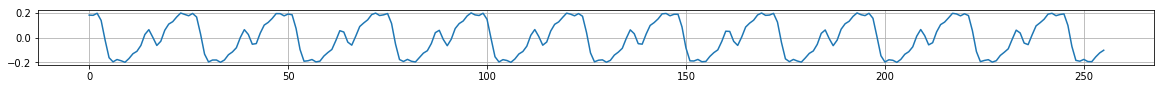

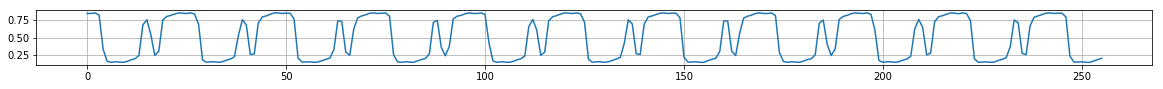

In [9]:
print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//params['batch_size'])

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = audiocoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

In [10]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return .1*torch.rand(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)-.05

In [11]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)


        # Forward + Backward + Optimize
        hidden = model.init_hidden(params['batch_size'])
        optimizer.zero_grad()
        loss = 0
        
        for i in range(params['seqLen']):
            outputs, hidden = model(inp[:,i,:],hidden,params['batch_size'])  #input dim: (batch, seq, feature)
            loss += criterion(outputs, torch.squeeze(target[:,i],1))
            
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/params['seqLen']   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, params['num_epochs'], step+1, len(adataset)//params['batch_size'], ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
            
        if (step+1) % visualize_interval == 0:
            result = generate(model,max_length)
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result) #just print one example from the batch
            plt.show()
            model.train() #put model back to training mode
            
        if (step+1) % params['savemodel_interval'] == 0 and params['savemodel'] and params['savemodel_interval'] != 0:
            lastSavedStep=k_previousRunSteps+step+1
            lastSavedModel=params['runTimeStamp']+'_model_epoch{}_step{}.pth'.format(epoch+1,lastSavedStep)
            torch.save(model.state_dict(), params['savemodeldir'] + '/' + lastSavedModel)
            print('model saved at epoch {} step {} for this run ({} overall)'.format(epoch+1,step+1, lastSavedStep))

            #write (overwrite) the param file for each save so we always have the latest, even if run doesn't complete
            params['savedSteps']=lastSavedStep
            params['savedModel']=lastSavedModel
            with open(params['savemodeldir'] + '/' + params['runTimeStamp'] + '_modelParams.pkl', 'wb') as output:
                    pickle.dump(params, output, pickle.HIGHEST_PROTOCOL)

                
        if step>=max_steps:
            break
            
        
        
# Define the training cycle (100% teacher forcing for now)
#*************************************
def generate(model,max_length,primer=None,paramvect=None, returnHiddenSequence=False):
    """Generate a signal using the provided model.
    @param max_length of the synthesized signal
    @param primer a torch.tensor of shape (batch=1, primer_signal=primer_length, num_inputs=1+num_cond_parameters)
    @paramvect conditioning parameters  (a function of i, sample number)
    """ 
    if returnHiddenSequence :
        hs=[]
        
    model.eval()
    with torch.no_grad():
        for p_inp,target in test_loader:
            if primer is not None:
                # must clone else primer is changed outside this function
                p_inp.data=primer.clone()
            seq = np.copy(p_inp[0,:,0])  #extract the original sample
            
            seq_mu = audiocoding(seq)  #mu-law
            p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
            break   
        generated = seq # before mu-law audio encoding
       
        p_inp = p_inp.to(device)
        #print("p_inp",p_inp)

        hidden = model.init_hidden()
        if returnHiddenSequence :
            hs.append(torch.squeeze(hidden).cpu().numpy())

            
        for j in range(params['seqLen']-1):  #build up hidden state
            _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        #print("last inp from primer",inp)
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.cuda.FloatTensor)
            #print("input",inp)
            #print("shape",inp.shape)
            if paramvect is not None:
                inp[:,1:] = torch.tensor(paramvect(i))
                #print("input2",inp)
                
            if returnHiddenSequence :
                hs.append(torch.squeeze(hidden).cpu().numpy())
                                       
        if returnHiddenSequence :
            return generated, hs
        else :
            return generated
        

<a href="#dataparams">Go To Data Params</a>

In [12]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(input_size=1,cond_size=len(params['props']),hidden_size=params['hiddenSize'],output_size=256,n_layers=params['nLayers']).to(device)
if loadmodel: # load checkpoint if needed
    print("Loading existing checkpoint...")
    rnn.load_state_dict(torch.load(loadmodelfile))
optimizer = torch.optim.Adam(rnn.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

2018-11-23 09:37:55 Starting training...
model saved at epoch 1 step 10 for this run (10 overall)
model saved at epoch 1 step 20 for this run (20 overall)
model saved at epoch 1 step 30 for this run (30 overall)
model saved at epoch 1 step 40 for this run (40 overall)
2018-11-23 09:38:18 Epoch [1/1], Step [50/48750] Loss: 4.9454
model saved at epoch 1 step 50 for this run (50 overall)
model saved at epoch 1 step 60 for this run (60 overall)
model saved at epoch 1 step 70 for this run (70 overall)
model saved at epoch 1 step 80 for this run (80 overall)
model saved at epoch 1 step 90 for this run (90 overall)
2018-11-23 09:38:39 Epoch [1/1], Step [100/48750] Loss: 4.6058


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8b89032f60>>
Traceback (most recent call last):
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/lonce/anaconda3/envs/snn/lib/python3.

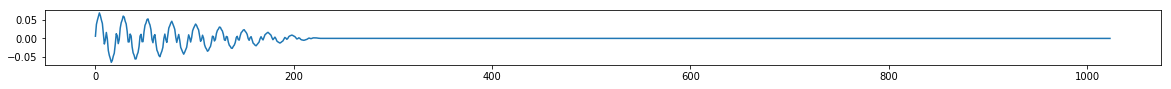

model saved at epoch 1 step 100 for this run (100 overall)
Training time taken: 0:00:46


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8b89066f28>>
Traceback (most recent call last):
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/lonce/anaconda3/envs/snn/lib/python3.

In [13]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(params['num_epochs']):
    train(rnn,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if params['savemodel_interval'] == 0 and params['savemodel']:
    torch.save(model.state_dict(), 
       '{}/{}_model_epoch{}.pth'.format(params['savemodeldir'],params['runTimeStamp'],params['num_epochs']))
    print('model saved at epoch{}'.format(params['num_epochs']))

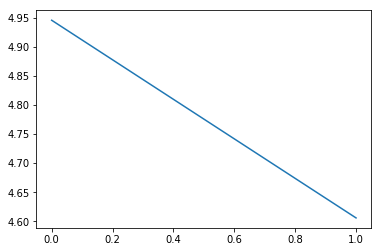

In [14]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)